In [174]:
#Import the packages
import nltk
import nltk.corpus
import pickle
import re
import pandas as pd
import numpy as np

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
nltk.download("stopwords") #Import stopwords and punctuation from NLTK
from string import punctuation
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/Z/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data and form corpora

In [175]:
trump_corpus = nltk.corpus.PlaintextCorpusReader('Clinton-Trump-Corpus/Trump/','Trump_.*.txt')

In [176]:
clinton_corpus = nltk.corpus.PlaintextCorpusReader('Clinton-Trump-Corpus/Clinton/','Clinton_.*.txt')

Below, we are doing conversions between the "raw" text, the tokenized "words", and the plain "text" type. This will be used later because some functions require a certain object type, and some methods are only callable from certain object types.

In [177]:
trump_raw = trump_corpus.raw()
trump_words = trump_corpus.words()
trump_text = nltk.Text(trump_words)

clinton_raw = clinton_corpus.raw()
clinton_words = clinton_corpus.words()
clinton_text = nltk.Text(clinton_words)

## Clean up the data
Get rid of applause, stop words, anything between < >, punctuation " -- . , '
Write a for loop to clean up all the data 



In [241]:
#this is a function that filters out the stopwords, punctuation, and audience directions in a given corpus

def clean_up_data(x):
    filtered_for_punctuation = x
    filtered_for_punctuation = filtered_for_punctuation.lower() #convert all words to lowercase
    filtered_for_punctuation = re.sub("[\(\<].*[\)\>]", "", filtered_for_punctuation) #remove audience directions
    for punc in punctuation:
        filtered_for_punctuation = filtered_for_punctuation.replace(punc, "") #remove punctuation
    filtered_for_punctuation = nltk.wordpunct_tokenize(filtered_for_punctuation) #tokenize text
    filtered_for_punctuation = [word for word in filtered_for_punctuation if word.lower() not in stopwords.words('english')] #remove stopwords
        #note that stopwords include words like very and against 
    #filtered_for_punctuation = str(filtered_for_punctuation) #this turns the tokens into strings again
    return filtered_for_punctuation

In [242]:
#clean up both corpora using the custom function from above
clean_trump = clean_up_data(trump_raw)
clean_clinton = clean_up_data(clinton_raw)

#join the corpora together while keeping them as separate entities as part of one 
#larger corpus umbrella
collected_corpora_df = {'clean_clinton' : clean_clinton, 'clean_trump' : clean_trump}
pd.Series(collected_corpora_df)

clean_clinton    [still, going, strong, powerful, military, inn...
clean_trump      [know, win, new, york, right, thank, chairman,...
dtype: object

## Load the "ANEW" sentiment dictionary
"ANEW" stands for "Affective Norms for English Words".
It is a list of 2476 words that have been normed for ratings on 3 affective dimensions: Valence, Arousal, and Dominance. The rating is on a Likert Scale ranging from 1 to 9, with a higher rating indicating higher valence, arousal, or dominance, respectively. Each word has a mean valence, arousal, and dominance rating, as well as the associated standard deviations for each mean.
"Wdnum" is presumably the "word number" or an arbitrary number label assigned to each word. We won't be using this variable in our sentiment analysis.

In [243]:
#load ANEW sentiment dictionary
anew_df = pd.read_csv('https://github.com/peachypunk/NLTK_Final_Project/raw/master/ANEW2010_CSV.csv')
anew_df.head()

,Word,Wdnum,ValMn,ValSD,AroMn,AroSD,DomMn,DomSD
0,abduction,621,2.76,2.06,5.53,2.43,3.49,2.38
1,able,1041,6.74,2.00,4.30,2.17,6.83,2.04
2,abortion,622,3.50,2.30,5.39,2.80,4.59,2.54
3,absent,1042,3.69,1.72,4.73,1.76,4.35,1.87
4,absurd,623,4.26,1.82,4.36,2.20,4.73,1.72


Below, we're taking all the words in anew_df and storing it in a list called "wordlist". This will make it easier to do word counting later.

In [244]:
#take the "Word" column from the anew_df and convert it into a list called "wordlist"
wordlist = anew_df["Word"].tolist()

## Perform word counting
To perform sentiment analysis based on the words from ANEW, we will first perform a word count of how many times each ANEW word appears in the Trump corpus and Clinton corpus, respectively.

In [245]:
#initialize an empty array for the summed word counts for each w in wordlist
#these will be summed across all corpora in the larger corpus as well
wordfreq_corpus = [] 

#make an empty matrix that's the size of the ANEX words and two corpora 
matrix = np.zeros((len(collected_corpora_df), len(wordlist)))
for i, cid in enumerate(collected_corpora_df): #for each corpus in the list of corpora
    this_corpus_words = collected_corpora_df[(cid)]
    for j, w in enumerate(wordlist): #for each word in the ANEW wordlist...
        count = this_corpus_words.count(w) #count how many times each word (w) occurs in the wordlist for each corpus
        matrix[i,j] = count
        
df = pd.DataFrame(matrix)
df.columns = wordlist
df.index = collected_corpora_df.keys()
#print(df)

#optional: print the output to a csv file. just change the "path_or_buf" part to be where you
#want to save the file
#df.to_csv(path_or_buf='/Users/angelanazarian/nltk_output.csv', sep=',', header=True, index=True, line_terminator='\n')


We successfully performed word counting: the above output contains the count for each ANEW word in the Clinton corpus and Trump corpus.

## Perform calculation of weighted MEANS for valence, arousal, and dominance
Using the word counts we obtained above, we will now calculate each weighted sum separately for each affective dimension (valenc, arousal, dominance) and for each corpus (Trump, Clinton).

For each word "w" in the ANEW word list: Weighted sum = sum of [count of "w" in the corpus x mean affective rating of "w" from ANEW], for each corpus

Below, we are converting the word count dataframe "df" into a transposed dataframe with sensible row indices and column labels. Essentially, we're converting "df" from wide format into long format to make it easier to calculate the weighted sums. The resulting dataframe is called "df_long".

In [246]:
df_wide = df.copy() #make a copy of df and calling it "df_wide"
df_long = df_wide.transpose() #transpose "df_wide" into "df_long" format
df_long.reset_index(level=0, inplace=True) #converting the ANEW word indices into numeric indices
df_long.columns = ['Word', 'clinton_WC', 'trump_WC'] #renaming columns (WC = word count)
df_long

,Word,clinton_WC,trump_WC
0,abduction,0.0,0.0
1,able,6.0,12.0
2,abortion,0.0,0.0
3,absent,0.0,0.0
4,absurd,0.0,0.0
5,abundance,0.0,0.0
6,abuse,1.0,0.0
7,accept,0.0,1.0
8,acceptance,1.0,0.0
9,access,2.0,7.0


In [247]:
anew_sliced = anew_df[['Word','ValMn', 'AroMn', 'DomMn']] 
anew_sliced #subsetting the mean ratings from ANEW df

,Word,ValMn,AroMn,DomMn
0,abduction,2.76,5.53,3.49
1,able,6.74,4.30,6.83
2,abortion,3.50,5.39,4.59
3,absent,3.69,4.73,4.35
4,absurd,4.26,4.36,4.73
5,abundance,6.59,5.51,5.80
6,abuse,1.80,6.83,3.69
7,accept,6.80,5.53,5.41
8,acceptance,7.98,5.40,6.64
9,access,6.14,5.07,6.25


In [248]:
df_combined = pd.merge(df_long, anew_sliced)
df_combined #combining df_long with anew_sliced into one dataframe

,Word,clinton_WC,trump_WC,ValMn,AroMn,DomMn
0,abduction,0.0,0.0,2.76,5.53,3.49
1,able,6.0,12.0,6.74,4.30,6.83
2,abortion,0.0,0.0,3.50,5.39,4.59
3,absent,0.0,0.0,3.69,4.73,4.35
4,absurd,0.0,0.0,4.26,4.36,4.73
5,abundance,0.0,0.0,6.59,5.51,5.80
6,abuse,1.0,0.0,1.80,6.83,3.69
7,accept,0.0,1.0,6.80,5.53,5.41
8,acceptance,1.0,0.0,7.98,5.40,6.64
9,access,2.0,7.0,6.14,5.07,6.25


We can now perform the calculation of weighted sums.

Below, each line of code calculates the product of each word's count in the corpus with the associated mean ratings of Valence, Arousal, and Dominance, and stores the value in a new appended column. The column multiplications are calcualted for all the rows (words) in the dataframe.

For example, the first line of code (below) calculates the weighted valence of each word in the Clinton corpus, based on how frequently that word occurs in the corpus (the word count). It takes clinton_WC and multiplies it by ValMn, and stores it in a new column called "clinton_Val".

In [249]:
# WORD COUNTS x VALENCE MEANS:

# "clinton_Val" = clinton_WC x ValMn
df_combined['clinton_Val'] = df_combined.apply(lambda row: (row['clinton_WC']*row['ValMn']), axis=1)

# "trump_Val" = trump_WC x ValMn
df_combined['trump_Val'] = df_combined.apply(lambda row: (row['trump_WC']*row['ValMn']), axis=1)



# WORD COUNTS x AROUSAL MEANS:

# "clinton_Aro" = clinton_WC x AroMn
df_combined['clinton_Aro'] = df_combined.apply(lambda row: (row['clinton_WC']*row['AroMn']), axis=1)

# "trump_Aro" = trump_WC x AroMn
df_combined['trump_Aro'] = df_combined.apply(lambda row: (row['trump_WC']*row['AroMn']), axis=1)



# WORD COUNTS x DOMINANCE MEANS:

# "clinton_Dom" = clinton_WC x DomMn
df_combined['clinton_Dom'] = df_combined.apply(lambda row: (row['clinton_WC']*row['DomMn']), axis=1)

# "trump_Val" = trump_WC x ValMn
df_combined['trump_Dom'] = df_combined.apply(lambda row: (row['trump_WC']*row['DomMn']), axis=1)



df_combined

,Word,clinton_WC,trump_WC,ValMn,AroMn,DomMn,clinton_Val,trump_Val,clinton_Aro,trump_Aro,clinton_Dom,trump_Dom
0,abduction,0.0,0.0,2.76,5.53,3.49,0.00,0.00,0.00,0.00,0.00,0.00
1,able,6.0,12.0,6.74,4.30,6.83,40.44,80.88,25.80,51.60,40.98,81.96
2,abortion,0.0,0.0,3.50,5.39,4.59,0.00,0.00,0.00,0.00,0.00,0.00
3,absent,0.0,0.0,3.69,4.73,4.35,0.00,0.00,0.00,0.00,0.00,0.00
4,absurd,0.0,0.0,4.26,4.36,4.73,0.00,0.00,0.00,0.00,0.00,0.00
5,abundance,0.0,0.0,6.59,5.51,5.80,0.00,0.00,0.00,0.00,0.00,0.00
6,abuse,1.0,0.0,1.80,6.83,3.69,1.80,0.00,6.83,0.00,3.69,0.00
7,accept,0.0,1.0,6.80,5.53,5.41,0.00,6.80,0.00,5.53,0.00,5.41
8,acceptance,1.0,0.0,7.98,5.40,6.64,7.98,0.00,5.40,0.00,6.64,0.00
9,access,2.0,7.0,6.14,5.07,6.25,12.28,42.98,10.14,35.49,12.50,43.75


## Perform calculation of weighted SUMS for valence, arousal, and dominance
Now that we have the weighted MEANS, we can calculate the weighted SUMS for valence, arousal, and dominance. This would be the overall "affectiveness" of each corpus on each affective dimension, based on the words in ANEW. It is calculated by summing the weighed means across all the words, and dividing that sum by the total number of words from that category (valence, arousal, or dominance) that were used by that candidate. This provided us with an average measure for each of those values. This approach was necessary because ANEW uses a 1-9 likert scale to qualify each of the measures rather than using negative numbers. So merely summing the values doesn’t reflect whether each candidate was more negative or positive. 


#### Weighted sums for VALENCE in each corpus:

In [250]:
#Sum of all values in "clinton_Val" column (summing across all words)
SUM_clinton_Val = (df_combined['clinton_Val'].values.sum())/((df_combined['clinton_Val'] != 0).sum())
print(SUM_clinton_Val)

#Sum of all values in "trump_Val" column (summing across all words)
SUM_trump_Val = (df_combined['trump_Val'].values.sum())/((df_combined['trump_Val'] != 0).sum())
print(SUM_trump_Val)

21.6853
49.9490328467


#### Weighted sums for AROUSAL in each corpus:

In [251]:
#Sum of all values in "clinton_Aro" column (summing across all words)
SUM_clinton_Aro = (df_combined['clinton_Aro'].values.sum())/((df_combined['clinton_Aro'] != 0).sum())
print(SUM_clinton_Aro)

#Sum of all values in "trump_Aro" column (summing across all words)
SUM_trump_Aro = (df_combined['trump_Aro'].values.sum())/((df_combined['trump_Aro'] != 0).sum()) 
print(SUM_trump_Aro)

19.2275
45.6030474453


#### Weighted sums for DOMINANCE in each corpus:

In [252]:
#Sum of all values in "clinton_Dom" column (summing across all words)
SUM_clinton_Dom = (df_combined['clinton_Dom'].values.sum())/((df_combined['clinton_Dom'] != 0).sum())
print(SUM_clinton_Dom)

#Sum of all values in "trump_Dom" column (summing across all words)
SUM_trump_Dom = (df_combined['trump_Dom'].values.sum())/((df_combined['trump_Dom'] != 0).sum())
print(SUM_trump_Dom)

19.928575
46.5444160584


For the 6 weighted sums that we just calculated, we will store them in a new dataframe so it's easier to compare the values.

First, we'll store the weighted sums in 2 separate lists for Trump and Clinton, respectively.

In [253]:
#Storing the calculated weighted sums in 2 separate lists for Trump corpus and Clinton corpus
trump_summed = ['Trump', SUM_trump_Val, SUM_trump_Aro, SUM_trump_Dom]
clinton_summed = ['Clinton', SUM_clinton_Val, SUM_clinton_Aro, SUM_clinton_Dom]

Then we will combine the two lists into a single dataframe.

In [254]:
#Creating a new dataframe that will store the calculated weighted sums
sums_df = pd.DataFrame({'Trump': trump_summed,'Clinton': clinton_summed})
sums_df = sums_df.transpose()
sums_df.columns = ['Candidate', 'Valence', 'Arousal', 'Dominance']
sums_df

,Candidate,Valence,Arousal,Dominance
Clinton,Clinton,21.6853,19.2275,19.9286
Trump,Trump,49.949,45.603,46.5444


## Interpretation of the calculated weighted sums:

This first round of analysis demonstrates that by comparing average values of valence, arousal, and dominance across all campaign speeches for both candidates, Trump emerged as the front runner on all three accounts. 

His speeches were higher in valence, the content had a higher arousal rate, and he displayed greater levels of dominance in his speech compared to Hillary. The valence findings initially threw me off, and were a bit unexpected...until we realized how many positive qualifiers and adjectives he tended to use in his speeches (i.e. huuuuuuge, very, incredible, best). In a way, this made me realize how it could be easy for his fans and listeners to be swayed by this exaggerated positive language, and gloss over the bullying, empty aspect of his speeches. 

Trump's higher valence ratings also match this story of greater exaggeration use. 

(should we run some stats tests to actually analyze this?)
(should we do separate analysis of exaggeration words, positive qualifiers, and adjectives?)


## Plots

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#plt.xticks(range(len(top20valence.Word)), top20valence.Word)
#sns.lmplot('Dominance', 'Valence', sums_df, hue = 'Candidate', fit_reg=False)

## Most frequent words for each candidate

In [256]:
# Calculate frequency distribution
clinton_fdist = nltk.FreqDist(clean_clinton)
top20clinton = pd.DataFrame(clinton_fdist.most_common(20))
top20clinton.columns = ['Word', 'frequency']

trump_fdist = nltk.FreqDist(clean_trump)
trump_fdist.most_common(20)
top20trump = pd.DataFrame(trump_fdist.most_common(20))
top20trump.columns = ['Word', 'frequency']

In [257]:
#top 20 words for both candidates in one dataframe
top20words = pd.merge(top20trump, top20clinton, on='Word', how='outer')
top20words.columns = ['Word', 'frequency_trump', 'frequency_clinton']

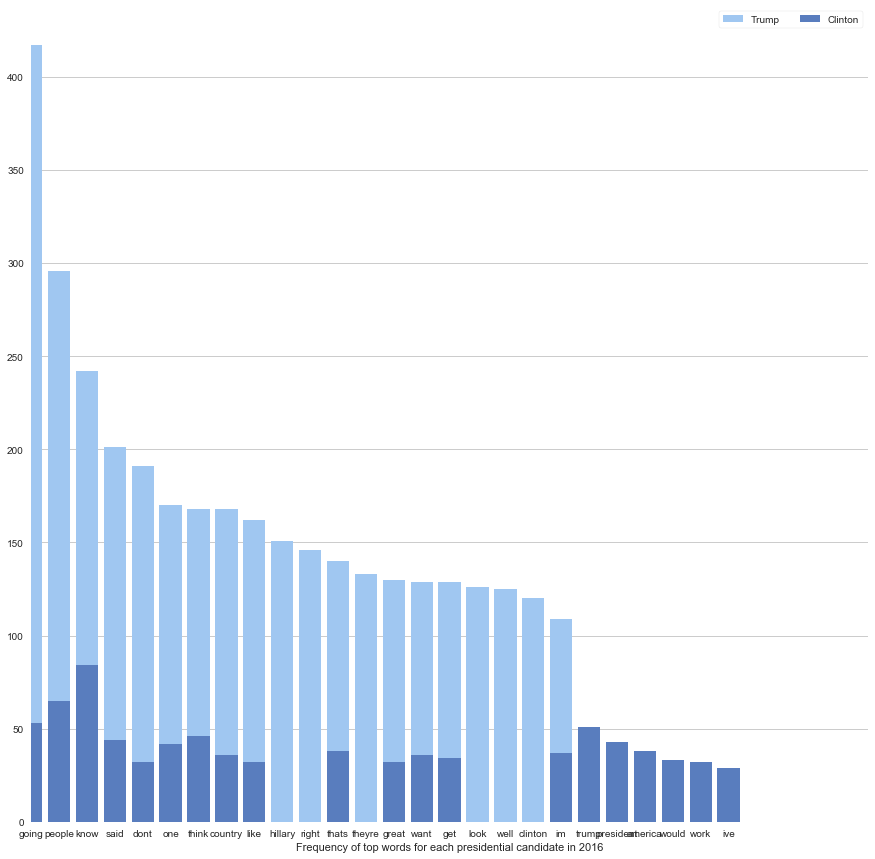

In [258]:
#plot top words for both candidates to see how much each person used those words
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))


# Plot the top word frequency for Trump
sns.set_color_codes("pastel")
sns.barplot(x="Word", y="frequency_trump", data=top20words,
            label="Trump", color="b")

#Plot the top word frequency for Clinton
sns.set_color_codes("muted")
sns.barplot(x="Word", y="frequency_clinton", data=top20words,
            label="Clinton", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(0, 30), ylabel="",
       xlabel="Frequency of top words for each presidential candidate in 2016")
sns.despine(left=True, bottom=True)

## Top words used by each candidate (along with visuals for valence of those words)

In [259]:
#this is a graph of the most frequently used words for each candidate and how many times each used it

#you can hover over the nodes to display the actual words
#it's actually kind of interesting to see the words that were exclusive to each of them (seen on the actual axes)
#for instance, although Trump was all about boosting employment, it's Hillary who used the word "work" the most
#Trump's uniquely most frequent word was "right"
import plotly.plotly as py
import plotly
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='peachypunk', api_key='zl14cGCYwyddRaQklh90')


data = [
    go.Scatter(
        x= top20valence.frequency_trump,
        y=top20valence.frequency_clinton,
        mode='markers',
        text=top20valence.Word
    )
]
layout = go.Layout(
    title='Words Most Frequently Used By Each Candidate',
    xaxis = dict(
        title='Trump Frequency'),
    yaxis = dict(
        title= 'Clinton Frequency'))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

NameError: name 'top20valence' is not defined

In [ ]:
#this is an even cooler version of the above which incorporates valence of each word by coloring the nodes
#like heat maps. this graph is my magnum opus
import plotly.plotly as py
import plotly
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='peachypunk', api_key='zl14cGCYwyddRaQklh90')


data = [
    go.Scatter(
        x= top20valence.frequency_trump,
        y=top20valence.frequency_clinton,
        mode='markers',
        marker=dict(
        size='16',
        color = top20valence.ValMn, #set color equal to a variable
        colorscale='YlOrRd',
        showscale=True
    ),
        text=top20valence.Word
    )
]
layout = go.Layout(
    title='Words Most Frequently Used By Each Candidate',
    xaxis = dict(
        title='Trump Frequency'),
    yaxis = dict(
        title= 'Clinton Frequency'))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Lexical Factors

In [ ]:
#calculate a measure of the lexical richness or lexical diversity of the text 
#this measure reflects the number of distinct words
print(len(set(clean_clinton)) / len(clean_clinton))
print(len(set(clean_trump)) / len(clean_trump))


In [ ]:
#count how often a word occurs in a text, and compute what percentage of the text is taken 
#up by a specific word. 
#we can do this for social media words (i.e. Facebook, tweet, Twitter, social media, online)

from collections import Counter
social_media_counts = Counter()
words = ('facebook', 'tweet', 'twitter', 'social media', 'online', 'email', 'emails')
for word in words:
    if word in clean_clinton:
        social_media_counts[word] += 1
print (social_media_counts)

#if you want to compute the percentage of text that uses these words, start here: 
#100 * social_media_clinton / len(clean_clinton)


In [ ]:
for word in words:
    if word in clean_trump:
        social_media_counts[word] += 1
print (social_media_counts)



## Words NOT captured by ANEW
After getting the weighted sums, we were curious about the words in the two corpora that were NOT in the ANEW list. Perhaps those words can give us better insight into the "affectiveness" of each presidential candidate's speeches.

To explore that question, we'll filter out the ANEW words from each corpus and examine the remaining words.

This is a function that filters out the ANEW words from the corpora.
The function will prune a text input by excluding a set of words. It takes "text_input" as the input. In the input, it'll exclude words that are in "words_to_exclude". It returns a list of words called "pruned_list", which contains the leftover words that WEREN'T in the "words_to_exclude" list.


In [ ]:
def excludewords(text_input, words_to_exclude):
    pruned_list = []
    for w in text_input:
        if w not in words_to_exclude:
            pruned_list.append(w)
    return pruned_list

Now we'll apply excludewords() on the cleaned trump corpus and clinton corpus, respectively.

In [ ]:
trump_pruned = excludewords(clean_trump, wordlist)
clinton_pruned = excludewords(clean_clinton, wordlist)

Let's see how many words weren't captured by ANEW:

In [ ]:
print(len(trump_pruned))
print(len(clinton_pruned))

So there are 37453 words in Trump corpus and 11670 words in Clinton corpus that were NOT in the ANEW list.

# Social Media

In [ ]:
#count how often a word occurs in a text, and compute what percentage of the text is taken 
#up by a specific word. 
#we can do this for social media words (i.e. Facebook, tweet, Twitter, social media, online)


In [ ]:
#Clinton Count
from collections import Counter
social_media_counts_clinton = Counter()
words = ('facebook', 'tweet', 'twitter', 'social media', 'online', 'email', 'emails', 'blog', 'google', 'hashtag', 'selfie', 'viral')
for word in clean_clinton:
    if word in words:
            social_media_counts_clinton[word] += 1
print(social_media_counts_clinton)

In [ ]:
#Trump Count
social_media_counts_trump = Counter()
words = ('facebook', 'tweet', 'twitter', 'social media', 'online', 'email', 'emails', 'blog', 'google', 'hashtag', 'selfie', 'viral')
for word in clean_trump:
    if word in words:
            social_media_counts_trump[word] += 1
print(social_media_counts_trump)

# Microvalence

In [ ]:
#trump_rewrite = ' '.join(clean_trump)
#trump_rewrite_tk = nltk.word_tokenize(trump_rewrite)
#clean_trump_text = Text(trump_rewrite_tk)

In [ ]:
clean_trump_text = nltk.Text(clean_trump)

In [ ]:
clean_trump_text.concordance("violence", 70, lines = 10)

In [ ]:
len(clean_trump_text)

In [ ]:
len(clean_trump)

In [ ]:

trump_text.concordance("hillary", 100, lines = 10)

In [ ]:
clean_trump_text.concordance("hillary", 100, lines = 10)

In [ ]:
len(clean_trump_text)

In [ ]:
len(trump_text)

In [ ]:
#testing trump_text
from collections import Counter
testtrump = Counter()
words = ('violence')
for word in clean_trump_text:
    if word in words:
        testtrump[words] += 1
print (testtrump)

In [ ]:
#testing trump_text
from collections import Counter
testtrump = Counter()
words = ('violence')
for word in trump_text:
    if word in words:
        testtrump[words] += 1
print (testtrump)

In [266]:
trump_text.concordance("violence", 70, lines = 10)
print(trump_text.similar("violence"))
print(clean_trump_text.similar("violence"))


Displaying 10 of 56 matches:
hen you have a track record of violence all over the world . What the 
mn the hatred , oppression and violence of radical Islam lacks the mor
as experiencing a reduction in violence . The group that would become 
ovides the breeding ground for violence and terrorism to grow . It ' s
ave seen the reports of sexual violence and assault far greater than a
icult times . < APPLAUSE > The violence , riots and destruction that h
nyone . < APPLAUSE > Crime and violence is an attack on the poor and w
 summer we have seen a wave of violence inspired by radical Islamists 
 hatred , the oppression , the violence of radical Islam lacks the mor
h , by the way , was workplace violence and not terrorism . How many t
people jobs you that money time years business mexico crime this
things drugs applause it millions us vote work trade
None

None


In [260]:
clean_trump_text = Text(clean_trump)

In [261]:
clean_trump_text

<Text: know win new york right thank chairman really...>

In [262]:
#testing clean_trump

from collections import Counter
testtrump = Counter()
words = ('violence')
for word in clean_trump_text:
    if word in words:
        testtrump[words] += 1
print (testtrump)

Counter({'violence': 11})


In [263]:
#export clean_trump to text file

trump_rewrite = ' '.join(clean_trump)

file = open('trump_rewrite.txt','w') 
 

file.write(str(trump_rewrite)) 
 
file.close() 

In [264]:
#export clean_trump to text file

title = trump

title = str(title)

trump_rewrite = ' '.join(trump_text)

file = open(title + 'trump_text.txt','w') 
 

file.write(str(trump_rewrite)) 
 
file.close() 

NameError: name 'trump' is not defined

In [265]:
def printtext(text2print, title):
    
    #export clean_trump to text file

    trump_print = ' '.join(clean_trump)

    file = open(title + 'trump_print.txt','w') 
 

    file.write(str(trump_rewrite)) 
 
    file.close() 
    
    'hanning(%d).pdf'
    
    
    
    
    
    
    for w in text_input:
        if w not in words_to_exclude:
            pruned_list.append(w)
    return pruned_list